Try to use an NN to classify patients in healthy (class 5) and non healthy (classes 1-4)

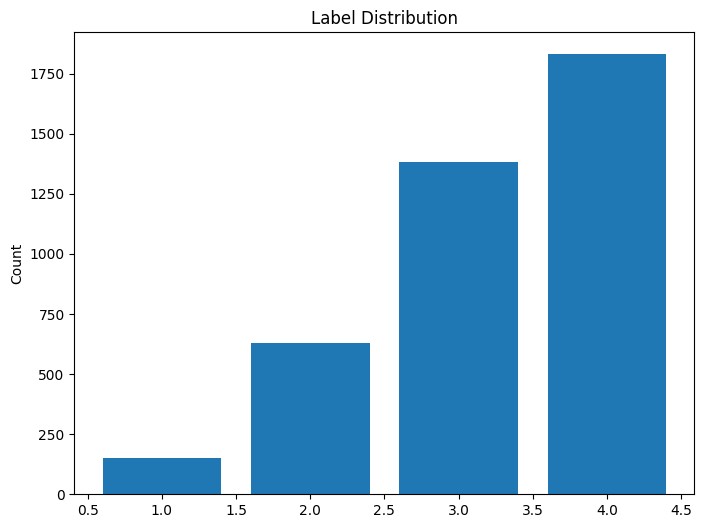

In [1]:
import numpy as np
# Load X and y
X = np.load('input_output/X_rhythm.npy')
y = np.load('input_output/y_rhythm.npy')

n_cl = 4

# select only records with argmax(y) between 0 and 3
indices = np.where(np.argmax(y, axis=1) < n_cl)[0]
X = X[indices]
y = y[indices]
# remove columns from y greater than n_cl
y = y[:, :n_cl]

# Check the distribution of the new labels
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(range(1, y.shape[1] + 1), np.sum(y, axis=0))
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

In [2]:
from sklearn.utils.class_weight import compute_class_weight

# Use all possible class indices for one-hot encoded y
class_weights = compute_class_weight('balanced', classes=np.arange(y.shape[1]), y=y.argmax(axis=1))

# format as a dict class: weight
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(6.65), 1: np.float64(1.5833333333333333), 2: np.float64(0.7228260869565217), 3: np.float64(0.5450819672131147)}


In [3]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1))


In [5]:
import tensorflow as tf

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,    #0.05               best with 0.001
  decay_steps=50, #100        best with 100
  decay_rate=5, #1              best with 1
  staircase=True)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=200, min_delta=0.001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=100):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            # batch_size=500,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            class_weight=class_weights,
            verbose=2)

    return history

In [6]:
from tensorflow.keras import layers, regularizers

INPUTDIM = X_train.shape[1]
OUTPUTDIM = y_train.shape[1]

n_train=X_train.shape[0]
n_val=X_val.shape[0]

dropout= 0.015
reg = 0.001

NN = tf.keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(INPUTDIM,),kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(256, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(128, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(OUTPUTDIM, activation='softmax')
])

history = compile_and_fit(NN, 'NN',X_train, y_train, X_val, y_val, max_epochs=2000)

bc     = history.history['accuracy']
val_bc = history.history['val_accuracy']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN training')
plt.grid(True)
#plt.show(block=False)

plt.legend(('Training','Validation'))
plt.show()



c:\Users\adriano.minora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,652 (1.05 MB)

 Trainable params: 275,652 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
100/100 - 3s - 35ms/step - accuracy: 0.5269 - loss: 1.8320 - val_accuracy: 0.6266 - val_loss: 1.7089
Epoch 2/2000
100/100 - 1s - 7ms/step - accuracy: 0.7152 - loss: 1.4668 - val_accuracy: 0.7068 - val_loss: 1.5360
Epoch 3/2000
100/100 - 1s - 6ms/step - accuracy: 0.7628 - loss: 1.3899 - val_accuracy: 0.7155 - val_loss: 1.5062
Epoch 4/2000
100/100 - 1s - 7ms/step - accuracy: 0.7807 - loss: 1.3475 - val_accuracy: 0.7381 - val_loss: 1.4802
Epoch 5/2000
100/100 - 1s - 7ms/step - accuracy: 0.7939 - loss: 1.3165 - val_accuracy: 0.7644 - val_loss: 1.4210
Epoch 6/2000
100/100 - 1s - 7ms/step - accuracy: 0.8105 - loss: 1.2881 - val_accuracy: 0.7682 - val_loss: 1.4149
Epoch 7/2000
100/100 - 1s - 6ms/step - accuracy: 0.8202 - loss: 1.2749 - val_accuracy: 0.7607 - val_loss: 1.3996
Epoch 8/2000
100/100 - 0s - 5ms/step - accuracy: 0.8180 - loss: 1.2651 - val_accuracy: 0.7782 - val_loss: 1.3774
Epoch 9/2000
100/100 - 1s - 5ms/step - accuracy: 0.8233 - loss: 1.2473 - val_accuracy: 0.7832 -

KeyboardInterrupt: 

Epoch 893/2000
48/48 - 0s - 9ms/step - accuracy: 0.9914 - loss: 0.7051 - val_accuracy: 0.9340 - val_loss: 0.9454

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 score: 0.9682495006616523


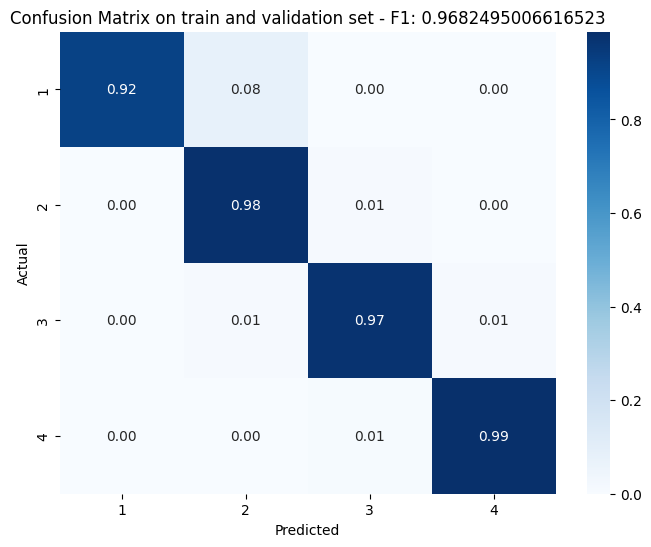

In [10]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(np.concatenate((y_val, y_train)), axis=-1)
y_pred = np.argmax(NN.predict(np.concatenate((X_val, X_train))), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set - F1: {f1}')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1 score: 0.8844203563007598


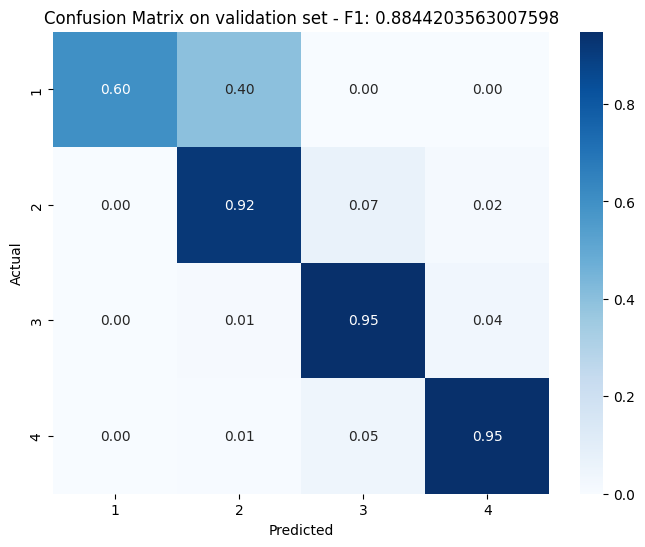

In [11]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(y_val, axis=-1)
y_pred = np.argmax(NN.predict(X_val), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set - F1: {f1}')
plt.show()

In [72]:
# Save the NN

save = False
if save:
    NN.save('NN_rhythm_categorical_1_4.keras')
    print("Model saved.")
else:
    print("Model not saved.")

Model not saved.


Now try for Male and Female separately

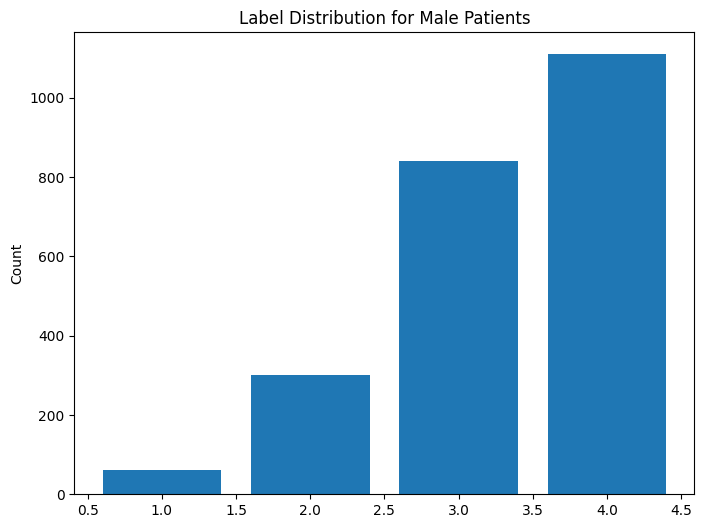

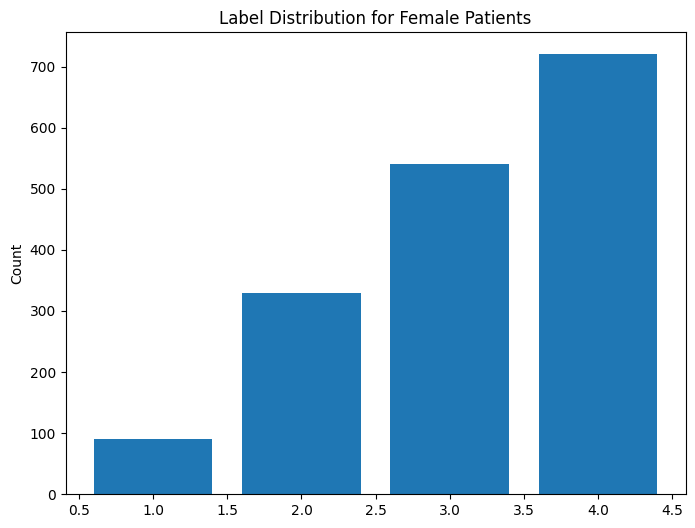

In [73]:
import numpy as np
# Load X and y
X_m = np.load('input_output/XM_rhythm.npy')
X_f = np.load('input_output/XF_rhythm.npy')
y_m = np.load('input_output/yM_rhythm.npy')
y_f = np.load('input_output/yF_rhythm.npy')

n_cl = 4

# select only records with argmax(y) between 0 and 3
indices_m = np.where(np.argmax(y_m, axis=1) < n_cl)[0]
indices_f = np.where(np.argmax(y_f, axis=1) < n_cl)[0]
X_m = X_m[indices_m]
X_f = X_f[indices_f]
y_m = y_m[indices_m]
y_f = y_f[indices_f]

# remove columns from y greater than n_cl
y_m = y_m[:, :n_cl]
y_f = y_f[:, :n_cl]

# Check the distribution of the new labels
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(range(1, y_m.shape[1] + 1), np.sum(y_m, axis=0))
plt.ylabel('Count')
plt.title('Label Distribution for Male Patients')
plt.show()

# Check the distribution of the new labels
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(range(1, y_f.shape[1] + 1), np.sum(y_f, axis=0))
plt.ylabel('Count')
plt.title('Label Distribution for Female Patients')
plt.show()

In [74]:
from sklearn.utils.class_weight import compute_class_weight

# Use all possible class indices for one-hot encoded y
class_weights_m = compute_class_weight('balanced', classes=np.arange(y_m.shape[1]), y=y_m.argmax(axis=1))
class_weights_f = compute_class_weight('balanced', classes=np.arange(y_f.shape[1]), y=y_f.argmax(axis=1))

# format as a dict class: weight
class_weights_m = dict(enumerate(class_weights_m))
class_weights_f = dict(enumerate(class_weights_f))

print(class_weights_m)
print(class_weights_f)

{0: np.float64(9.625), 1: np.float64(1.925), 2: np.float64(0.6875), 3: np.float64(0.5202702702702703)}
{0: np.float64(4.666666666666667), 1: np.float64(1.2727272727272727), 2: np.float64(0.7777777777777778), 3: np.float64(0.5833333333333334)}


In [75]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_m, y_m, test_size=0.2, random_state=42, stratify=y_m.argmax(axis=1))
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_f, y_f, test_size=0.2, random_state=42, stratify=y_f.argmax(axis=1))


Male

In [77]:
import tensorflow as tf

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,    #0.05               best with 0.001
  decay_steps=50, #100        best with 100
  decay_rate=5, #1              best with 1
  staircase=True)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=200, min_delta=0.001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=100):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            # batch_size=500,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            class_weight=class_weights_m,
            verbose=2)

    return history

c:\Users\adriano.minora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_116 (Dense)               │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341,444 (1.30 MB)

 Trainable params: 341,444 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
58/58 - 5s - 80ms/step - accuracy: 0.5173 - loss: 3.0066 - val_accuracy: 0.6905 - val_loss: 2.5254
Epoch 2/2000
58/58 - 1s - 9ms/step - accuracy: 0.7760 - loss: 2.3189 - val_accuracy: 0.7835 - val_loss: 2.2432
Epoch 3/2000
58/58 - 0s - 8ms/step - accuracy: 0.8144 - loss: 2.1745 - val_accuracy: 0.8442 - val_loss: 2.1293
Epoch 4/2000
58/58 - 0s - 8ms/step - accuracy: 0.8506 - loss: 2.0857 - val_accuracy: 0.8571 - val_loss: 2.0594
Epoch 5/2000
58/58 - 0s - 6ms/step - accuracy: 0.8582 - loss: 2.0535 - val_accuracy: 0.8766 - val_loss: 2.0048
Epoch 6/2000
58/58 - 0s - 8ms/step - accuracy: 0.8690 - loss: 2.0193 - val_accuracy: 0.8593 - val_loss: 1.9891
Epoch 7/2000
58/58 - 0s - 8ms/step - accuracy: 0.8669 - loss: 1.9921 - val_accuracy: 0.8658 - val_loss: 1.9677
Epoch 8/2000
58/58 - 0s - 6ms/step - accuracy: 0.8799 - loss: 1.9565 - val_accuracy: 0.8723 - val_loss: 1.9380
Epoch 9/2000
58/58 - 0s - 7ms/step - accuracy: 0.8761 - loss: 1.9553 - val_accuracy: 0.8745 - val_loss: 1.9210


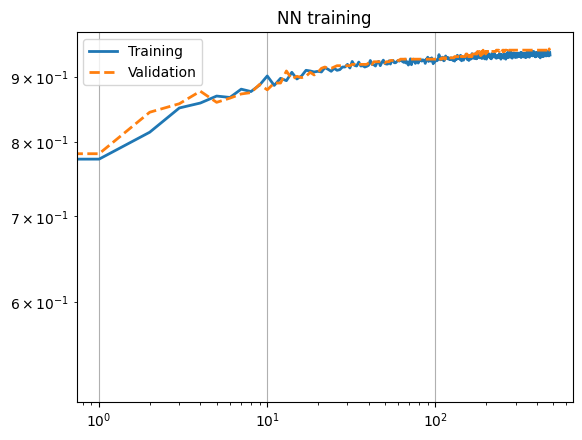

In [78]:
from tensorflow.keras import layers, regularizers

INPUTDIM = X_train_m.shape[1]
OUTPUTDIM = y_train_m.shape[1]

n_train_m=X_train_m.shape[0]
n_val_m=X_val_m.shape[0]

dropout= 0.02
reg = 0.002

NN = tf.keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(INPUTDIM,),kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(256, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(256, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(128, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(OUTPUTDIM, activation='softmax')
])

history = compile_and_fit(NN, 'NN',X_train_m, y_train_m, X_val_m, y_val_m, max_epochs=2000)

bc     = history.history['accuracy']
val_bc = history.history['val_accuracy']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN training')
plt.grid(True)
#plt.show(block=False)

plt.legend(('Training','Validation'))
plt.show()



Epoch 481/2000
58/58 - 0s - 6ms/step - accuracy: 0.9356 - loss: 1.4802 - val_accuracy: 0.9437 - val_loss: 1.4175

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1 score: 0.8243665930975574


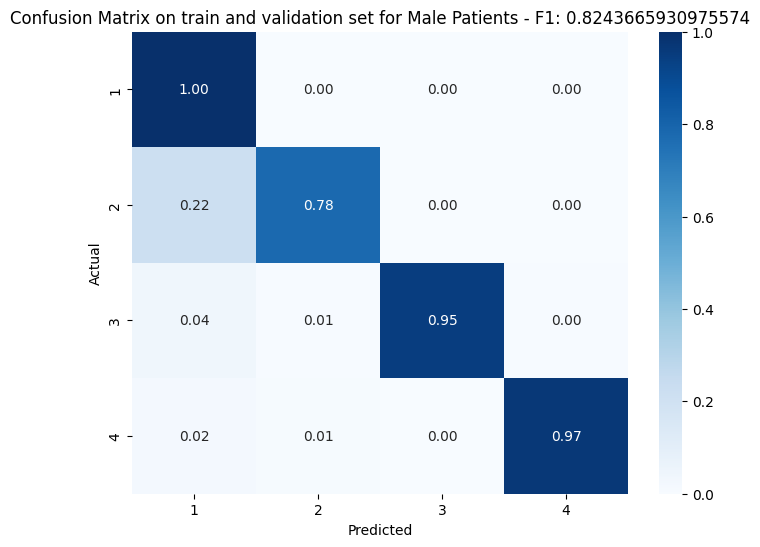

In [79]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(np.concatenate((y_val_m, y_train_m)), axis=-1)
y_pred = np.argmax(NN.predict(np.concatenate((X_val_m, X_train_m))), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set for Male Patients - F1: {f1}')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1 score: 0.8475185136657184


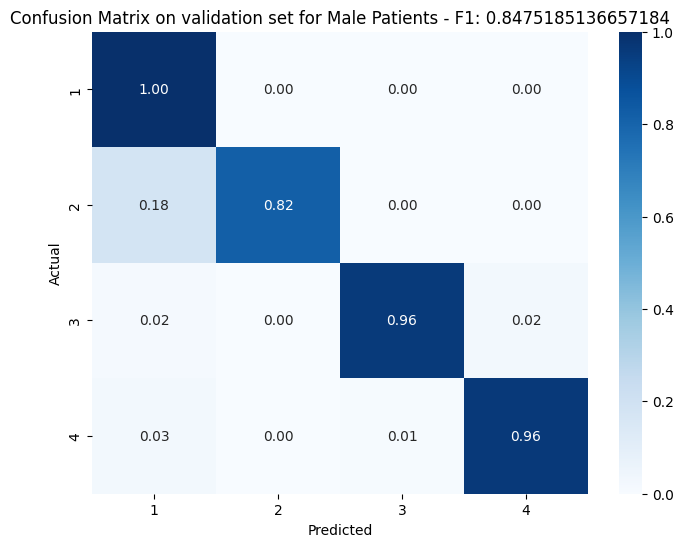

In [80]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(y_val_m, axis=-1)
y_pred = np.argmax(NN.predict(X_val_m), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set for Male Patients - F1: {f1}')
plt.show()

In [82]:
# Save the NN

save = False
if save:
    NN.save('models/NN_rhythm_categorical_1_4_M.keras')
    print("Model saved.")
else:
    print("Model not saved.")

Model not saved.


Female

In [83]:
import tensorflow as tf

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,    #0.05               best with 0.001
  decay_steps=50, #100        best with 100
  decay_rate=5, #1              best with 1
  staircase=True)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=400, min_delta=0.001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=100):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            # batch_size=500,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            class_weight=class_weights_f,
            verbose=2)

    return history

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_128 (Dense)               │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,188 (1.29 MB)

 Trainable params: 337,188 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
42/42 - 2s - 54ms/step - accuracy: 0.4152 - loss: 2.2576 - val_accuracy: 0.5863 - val_loss: 1.7493
Epoch 2/2000
42/42 - 0s - 5ms/step - accuracy: 0.6823 - loss: 1.5494 - val_accuracy: 0.6815 - val_loss: 1.4936
Epoch 3/2000
42/42 - 0s - 5ms/step - accuracy: 0.7366 - loss: 1.4150 - val_accuracy: 0.7411 - val_loss: 1.3843
Epoch 4/2000
42/42 - 0s - 5ms/step - accuracy: 0.7693 - loss: 1.3501 - val_accuracy: 0.7560 - val_loss: 1.3366
Epoch 5/2000
42/42 - 0s - 5ms/step - accuracy: 0.7827 - loss: 1.2990 - val_accuracy: 0.7708 - val_loss: 1.2940
Epoch 6/2000
42/42 - 0s - 6ms/step - accuracy: 0.8028 - loss: 1.2639 - val_accuracy: 0.7768 - val_loss: 1.2561
Epoch 7/2000
42/42 - 0s - 6ms/step - accuracy: 0.8095 - loss: 1.2383 - val_accuracy: 0.7798 - val_loss: 1.2408
Epoch 8/2000
42/42 - 0s - 5ms/step - accuracy: 0.8132 - loss: 1.2145 - val_accuracy: 0.7827 - val_loss: 1.2101
Epoch 9/2000
42/42 - 0s - 6ms/step - accuracy: 0.8281 - loss: 1.1921 - val_accuracy: 0.7887 - val_loss: 1.2014


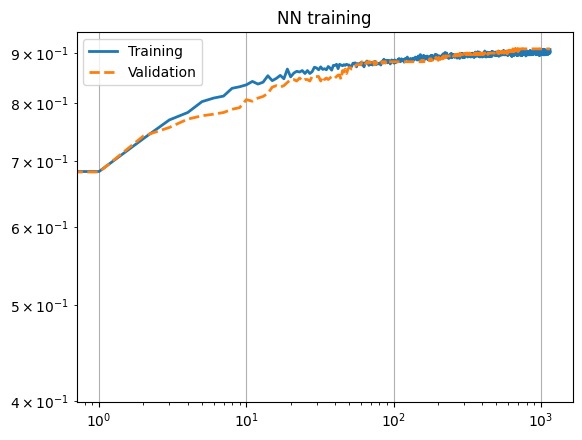

In [85]:
from tensorflow.keras import layers, regularizers

INPUTDIM = X_train_f.shape[1]
OUTPUTDIM = y_train_f.shape[1]

n_train_f=X_train_f.shape[0]
n_val_f=X_val_f.shape[0]

dropout= 0.02
reg = 0.002

NN = tf.keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(INPUTDIM,),kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(256, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(256, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(128, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(32, activation='relu', kernel_regularizer = regularizers.l2(reg)),
    layers.Dropout(dropout),
    layers.Dense(OUTPUTDIM, activation='softmax')
])

history = compile_and_fit(NN, 'NN',X_train_f, y_train_f, X_val_f, y_val_f, max_epochs=2000)

bc     = history.history['accuracy']
val_bc = history.history['val_accuracy']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN training')
plt.grid(True)
#plt.show(block=False)

plt.legend(('Training','Validation'))
plt.show()



Epoch 1156/2000
42/42 - 0s - 6ms/step - accuracy: 0.9062 - loss: 0.7354 - val_accuracy: 0.9077 - val_loss: 0.7226

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
F1 score: 0.8291531685430925


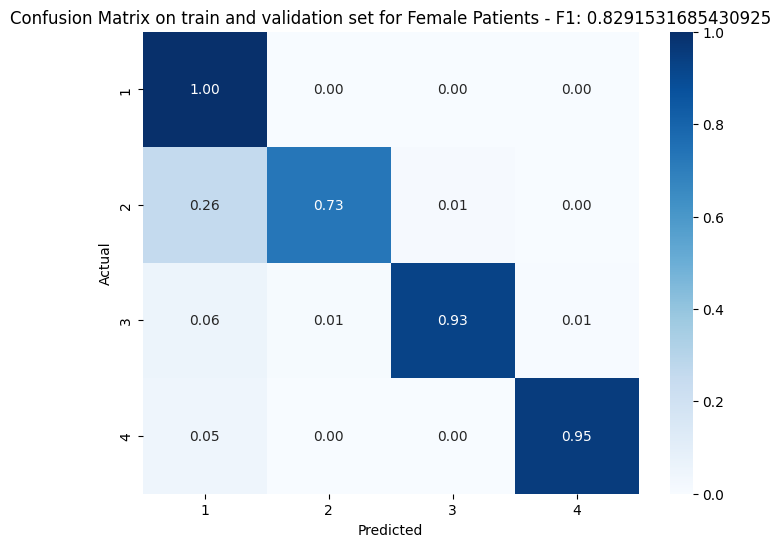

In [86]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(np.concatenate((y_val_f, y_train_f)), axis=-1)
y_pred = np.argmax(NN.predict(np.concatenate((X_val_f, X_train_f))), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on train and validation set for Female Patients - F1: {f1}')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1 score: 0.831104802271467


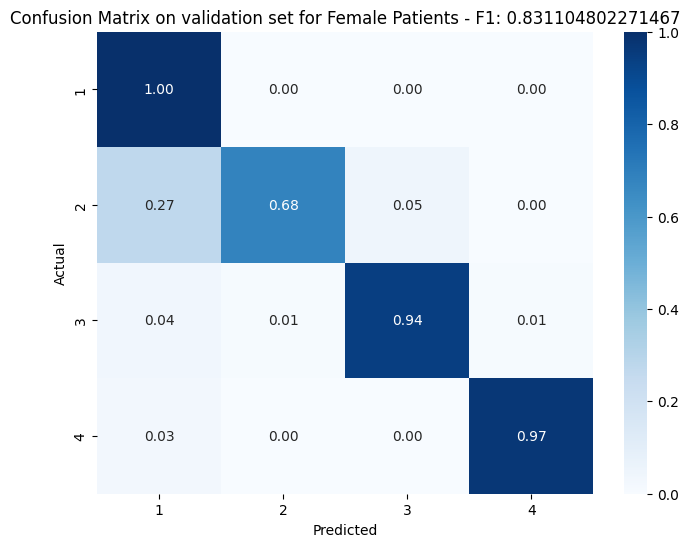

In [87]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

# Example true labels and predicted labels
y_true = np.argmax(y_val_f, axis=-1)
y_pred = np.argmax(NN.predict(X_val_f), axis=-1)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 score:', f1)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_cl), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(1,n_cl+1), yticklabels=range(1,n_cl+1))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix on validation set for Female Patients - F1: {f1}')
plt.show()

In [ ]:
# Save the NN

save = False
if save:
    NN.save('models/NN_rhythm_categorical_1_4_F.keras')
    print("Model saved.")
else:
    print("Model not saved.")

Model saved.
